- 어텐션 매커니즘(Attention Mechanism)
  - 자연어 처리와 컴퓨터비전에 서 핵심역활
  - 시퀀스 데이터 처리에서 특정 부분에 집중할 수 있도록 도와준다  
- 기존 RNN 문제점
  -  RNN ,LSTM 순차 데이터를 다룰수 있고 긴 문장을 처리할때 다음과 같은 한계
    - 장기 의존성 문제
      - 입력 길이가 길어질수록 초반 입력의 정보가 후반에 잘 전달되지 않음(그레이디언트 소실)
      - 병렬 연산불가
        - 시퀀스데이터 특성상 병렬 처리가 어렵고 학습 속도가 느림
      - 고정된 컨텍스트 벡터 문제
        - 기존 seq2seq 모델에서는 전체 문장을 하나의  벡터로 인코딩하므로, 정보손실이 발생

트랜스포머의 구조
  - 인코더와 디코더로 구성된 모델
  - 각각 인코더와 디코더 블럭은 Multi-Head Self-Attention + Feed Forward Network(FFN)
  - Self Attention
    - 트랜스포커는 각 단어가 문장 내 다른 단어와 얼마나 관련 있는지 계산하는 것
    - 기존 RNN과 다른점은 모든 단어를 한 번에 고려할 수 있도록 한다
    - 입력을 Query(Q), key(k), value(V)로 변환
    - 어텐션 스코어 계산


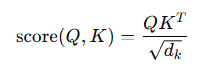


소프트맥스 정규화 후 가중치 적용

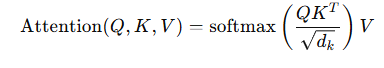


어텐션 코드

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
# 사용자 정의 모델(토치의 모델클래스를 상속받아서)
class ScaledDotProductAttention(nn.Module):
  # 초기화
  def __init__(self, d_k):
    super(ScaledDotProductAttention, self).__init__()  # 부모의 속성을 상속받아서 사용 할 수 있도록
    self.d_k = d_k
  # 어텐션 연산  함수이름이 forward로 정해져있음.. 즉.. 부모의 forward를 재 정의
  def forward(self, Q, K ,V):
    # K.transpose(-2, -1) # Key 행렬의 차원을 변경하여 행렬 곱 연산 가능하게 조정
    # torch.matmul(Q, K.transpose(-2, -1))  Q 와 K를 내적해서 유사도 점수 Attention Score 계산
    attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k,dtype=torch.float32))  # Sfotmax적용전 스케일링 연산
    attention_weights = F.softmax(attention_scores, dim=-1)  # softmax함수를 적용해 확률 값(가중치)을 계산
    output = torch.matmul(attention_weights, V) # 어텐션 가중치와 value 행렬을 곱해서 최종 출력을 생성
    return output, attention_weights,attention_scores


테스트 데이터 생성 및 실행

In [3]:
d_k = 64 # key의 차원
batch_size, seq_len, d_model = 2,5,64
# 배치크기 :2 한번에 2개의 문장을 처리
# 시퀀스길이 : 5 각 문장이 5개의 단어로 구성
# 모델 차원 : 64  각 단어를 64차원 벡터로 표현

Q = torch.rand(batch_size, seq_len, d_model)
K = torch.rand(batch_size, seq_len, d_model)
V = torch.rand(batch_size, seq_len, d_model)

In [7]:
attention = ScaledDotProductAttention(d_k)
output, attention_weights,attention_scores = attention(Q, K, V)


In [8]:
print("어텐션 출력 크기:",output.shape)
print("어텐션 가중치 크기:",attention_weights.shape)
print("어텐션 스코어 크기:",attention_scores.shape)


어텐션 출력 크기: torch.Size([2, 5, 64])
어텐션 가중치 크기: torch.Size([2, 5, 5])
어텐션 스코어 크기: torch.Size([2, 5, 5])


In [9]:
attention_scores

tensor([[[2.2319, 1.9291, 2.0628, 1.7988, 2.5103],
         [2.2370, 2.0451, 2.2670, 1.9474, 2.6199],
         [2.2245, 2.1048, 2.1830, 1.8557, 2.6288],
         [1.9262, 1.8138, 1.9285, 1.6872, 2.2015],
         [1.9930, 1.8105, 2.0162, 1.7061, 2.2203]],

        [[1.8207, 2.2764, 2.2091, 2.3287, 2.1513],
         [1.9785, 2.3894, 2.4953, 2.5732, 2.2327],
         [1.9537, 2.2079, 2.2572, 2.3654, 2.1794],
         [1.7433, 1.8932, 2.0319, 2.1063, 1.9805],
         [2.0100, 2.1099, 2.2333, 2.3094, 2.0905]]])

In [13]:
attention_scores[0,0,2]  # 첫번째 문장의 첫번째 단어와 세번째 단어의 유사도 점수가 2.0628

tensor(2.0628)

In [10]:
attention_weights  # 각 행의 합이 1이 되는 확률 값이다  한 단어가 다른 단어에 얼마나 영향을 주는지 표현

tensor([[[0.2196, 0.1623, 0.1855, 0.1424, 0.2902],
         [0.1972, 0.1628, 0.2032, 0.1476, 0.2892],
         [0.1986, 0.1762, 0.1905, 0.1373, 0.2975],
         [0.2000, 0.1787, 0.2004, 0.1575, 0.2634],
         [0.2057, 0.1713, 0.2105, 0.1544, 0.2581]],

        [[0.1407, 0.2220, 0.2075, 0.2339, 0.1959],
         [0.1372, 0.2070, 0.2301, 0.2487, 0.1770],
         [0.1561, 0.2013, 0.2114, 0.2356, 0.1956],
         [0.1612, 0.1873, 0.2152, 0.2318, 0.2044],
         [0.1728, 0.1909, 0.2160, 0.2331, 0.1872]]])

In [15]:
attention_weights[0,0,2]

tensor(0.1855)

In [14]:
sum([0.2196, 0.1623, 0.1855, 0.1424, 0.2902])

1.0

트랜스포머 모델 주요 구성 요소
 - Positional Encoding: 단어의 순서 정보를 추가하는 역할
 - Multi-Head Attention: 여러 개의 Self-Attention을 병렬로 적용
 - Feed Forward Network: 비선형 변환을 수행하는 완전연결층
 - Layer Normalization & Residual Connection: 학습을 안정화시키는 역할
 - Transformer Encoder Block: 위 요소들을 조합하여 Transformer를 구성

Positional Encoding
  - Transformer 모델은 CNN이나 RNN처럼 단어 순서를 고려하지 않음.
  - 하지만 자연어 처리에서는 단어의 순서 정보가 중요하므로,
  - Positional Encoding을 사용하여 위치 정보를 추가한다.
  - 우리는 sin, cos 함수를 이용한 고유한 위치 정보를 생성

In [16]:
import torch
import torch.nn as nn
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model) # (max_len, d_model) 크기의 행렬 생성
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # 위치값 (0 ~ max_len)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) # 짝수 인덱스에 sin 함수 적용
        pe[:, 1::2] = torch.cos(position * div_term) # 홀수 인덱스에 cos 함수
        pe = pe.unsqueeze(0) # 배치 차원 추가
        self.register_buffer('pe', pe) # 학습되지 않은 값으로 저장

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

Multi-Head Attention
  - 각각의 어텐션 헤드가 서로 다른 정보를 학습할 수 있다

In [24]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0  # num_heads는 d_model의 약수여야 함
        self.d_k = d_model // num_heads  # 각 헤드의 차원
        self.num_heads = num_heads

        # W_q, W_k, W_v: Query, Key, Value를 위한 가중치 행렬
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)  # 최종 출력 변환

    def forward(self, Q, K, V):
        batch_size = Q.size(0)

        # Query, Key, Value를 (batch, seq_len, d_model) → (batch, seq_len, num_heads, d_k)로 변환
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled Dot-Product Attention 적용
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)
        output = torch.matmul(attention_weights, V)

        # (batch, num_heads, seq_len, d_k) → (batch, seq_len, d_model)로 변환   마지막에 헤드를 다시 합쳐서 출력 차원을 유지
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.W_o(output)


Feed Forward network (FFN)
  - 완전연결층을 적용해서 비선형 변환을 수행

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, d_model, d_ff):
     super(FeedForward, self).__init__()
     self.linear1 = nn.Linear(d_model, d_ff)
     self.relu = nn.ReLU()
     self.linear2 = nn.Linear(d_ff, d_model)
  def forward(self, x):
    return self.linear2(self.relu(self.linear1(x)))

Transformer Encoder Layer (단일 레이어)
  - Multi_Head Attenrion + FFN + LayerNorm

In [25]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

Transformer Encoder (전체 모델)
  - 여러개의 Encoder Layer를 쌓아서 모델을 구성

In [26]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, vocab_size, max_len):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([TransformerEncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)
